<a href="https://colab.research.google.com/github/tkasod2/TIL/blob/main/prj_analysis/Retailrocket_recommender_system_datase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data link : https://www.kaggle.com/retailrocket/ecommerce-dataset


## Context
The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (itemproperties.сsv) and a file, which describes category tree (categorytree.сsv). The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues. The purpose of publishing is to motivate researches in the field of recommender systems with implicit feedback.

## Content
The behaviour data, i.e. events like clicks, add to carts, transactions, represent interactions that were collected over a period of 4.5 months. A visitor can make three types of events, namely “view”, “addtocart” or “transaction”. In total there are 2 756 101 events including 2 664 312 views, 69 332 add to carts and 22 457 transactions produced by 1 407 580 unique visitors. For about 90% of events corresponding properties can be found in the “item_properties.csv” file.

For example:

“1439694000000,1,view,100,” means visitorId = 1, clicked the item with id = 100 at 1439694000000 (Unix timestamp)
“1439694000000,2,transaction,1000,234” means visitorId = 2 purchased the item with id = 1000 in transaction with id = 234 at 1439694000000 (Unix timestamp)
The file with item properties (item_properties.csv) includes 20 275 902 rows, i.e. different properties, describing 417 053 unique items. File is divided into 2 files due to file size limitations. Since the property of an item can vary in time (e.g., price changes over time), every row in the file has corresponding timestamp. In other words, the file consists of concatenated snapshots for every week in the file with the behaviour data. However, if a property of an item is constant over the observed period, only a single snapshot value will be present in the file.
For example, we have three properties for single item and 4 weekly snapshots, like below:

Because property=100 is constant over time, property=200 has different values for all snapshots, property=300 has been changed once.

Item properties file contain timestamp column because all of them are time dependent, since properties may change over time, e.g. price, category, etc. Initially, this file consisted of snapshots for every week in the events file and contained over 200 millions rows. We have merged consecutive constant property values, so it's changed from snapshot form to change log form. Thus, constant values would appear only once in the file. This action has significantly reduced the number of rows in 10 times.

All values in the “item_properties.csv” file excluding "categoryid" and "available" properties were hashed. Value of the "categoryid" property contains item category identifier. Value of the "available" property contains availability of the item, i.e. 1 means the item was available, otherwise 0. All numerical values were marked with "n" char at the beginning, and have 3 digits precision after decimal point, e.g., "5" will become "n5.000", "-3.67584" will become "n-3.675". All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"

The category tree file has 1669 rows. Every row in the file specifies a child categoryId and the corresponding parent.
For example:

Line “100,200” means that categoryid=1 has parent with categoryid=200
Line “300,” means that categoryid hasn’t parent in the tree
## Acknowledgements
Retail Rocket (retailrocket.io) helps web shoppers make better shopping decisions by providing personalized real-time recommendations through multiple channels with over 100MM unique monthly users and 1000+ retail partners over the world.

## Inspiration
How to use item properties and category tree data to improve collaborative filtering model?
Recurrent Neural Networks with Top-k Gains for Session-based Recommendations https://github.com/hidasib/GRU4Rec and paper https://arxiv.org/abs/1706.03847
https://www.researchgate.net/publication/280538158_Application_of_Kullback-Leibler_divergence_for_short-term_user_interest_detection
https://pdfs.semanticscholar.org/66dc/1724c4ed1e74fe6b22e636b52031a33c8ebe.pdf https://www.slideshare.net/LukasLerche/adaptation-and-evaluation-of-recommendationsfor-shortterm-shopping-goals Adaptation and Evaluation of Recommendations for Short-term Shopping Goals
## Tasks
### Task 1
When a customer comes to an e-commerce site, he looks for a product with particular properties: price range, vendor, product type and etc. These properties are implicit, so it's hard to determine them through clicks log.

Try to create an algorithm which predicts properties of items in "addtocart" event by using data from "view" events for any visitor in the published log.

### Task 2
#### Description:
Process of analyzing ecommerce data include very important part of data cleaning. Researchers noticed that in some cases browsing data include up to 40% of abnormal traffic.

Firstly, abnormal users add a lot of noise into data and make recommendation system less effective. In order to increase efficiency of recommendation system, abnormal users should be removed from the raw data.

Secondly, abnormal users add bias to results of split tests, so this type of users should be removed also from split test data.

#### Goals:
The main goal is to find abnormal users of e-shop.

#### Subgoals:
Generate features
Build a model
Create a metric that helps to evaluate quality of the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !unzip -qq '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store.zip' -d '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store'

# GPU Check
!nvidia-smi

# # CPU Check
# !head /proc/cpuinfo

# # RAM
# !head -n 3 /proc/meminfo

Mounted at /content/drive
Mon Jan 24 08:06:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
import pandas as pd
import os

In [ ]:
PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'

FILES = [x for x in os.listdir(PATH) if x.find('.csv')>0]
FILES = [x.split('.csv')[0] for x in FILES]

def readcsv(x):
  return pd.read_csv(PATH + x)

for i in FILES:
  globals()[f'df_{i}'] = readcsv(i+'.csv') # 전역변수 사용해서, data 읽어오기

In [ ]:
import datetime
def ts_to_dt(df_old):
  df = df_old.copy()
  for col in df.columns:
    if col == 'timestamp':
      df['datetime'] = (df['timestamp']/1000).apply(datetime.datetime.fromtimestamp) # timestamp에서 datetime 으로 바꿀때 1000을 나눠줘야한다.
      df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
    else:
      pass
  return df

In [ ]:
df_events.info(null_counts= True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   timestamp      2756101 non-null  int64         
 1   visitorid      2756101 non-null  int64         
 2   event          2756101 non-null  object        
 3   itemid         2756101 non-null  int64         
 4   transactionid  22457 non-null    float64       
 5   datetime       2756101 non-null  datetime64[ns]
 6   date           2756101 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


In [ ]:
df_events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [ ]:
events = ts_to_dt(df_events)

In [ ]:
item_pro1 = ts_to_dt(df_item_properties_part1)
item_pro2 = ts_to_dt(df_item_properties_part2)
item_pro2.head()

,timestamp,itemid,property,value,datetime,date
0,1433041200000,183478,561,769062,2015-05-31 03:00:00,2015-05-31
1,1439694000000,132256,976,n26.400 1135780,2015-08-16 03:00:00,2015-08-16
2,1435460400000,420307,921,1149317 1257525,2015-06-28 03:00:00,2015-06-28
3,1431831600000,403324,917,1204143,2015-05-17 03:00:00,2015-05-17
4,1435460400000,230701,521,769062,2015-06-28 03:00:00,2015-06-28


In [ ]:
df_item = pd.concat([item_pro1, item_pro2],ignore_index = True)
df_item.head()

NameError: ignored

In [ ]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   datetime       datetime64[ns]
 6   date           object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


In [ ]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  int64         
 1   itemid     int64         
 2   property   object        
 3   value      object        
 4   datetime   datetime64[ns]
 5   date       object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 928.2+ MB


In [ ]:
# # pickle 저장
# events.to_pickle(PATH+"/df_event.pkl")
# df_item.to_pickle(PATH+"/df_item.pkl")

## ✅Data load < --- 여기부터 시작

In [58]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
import datetime

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Feb  1 03:25:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [2]:
# pickle load
PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'
df_event = pd.read_pickle(PATH+"/df_event.pkl")
# df_item = pd.read_pickle(PATH+"/df_item.pkl")

## ✅events

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

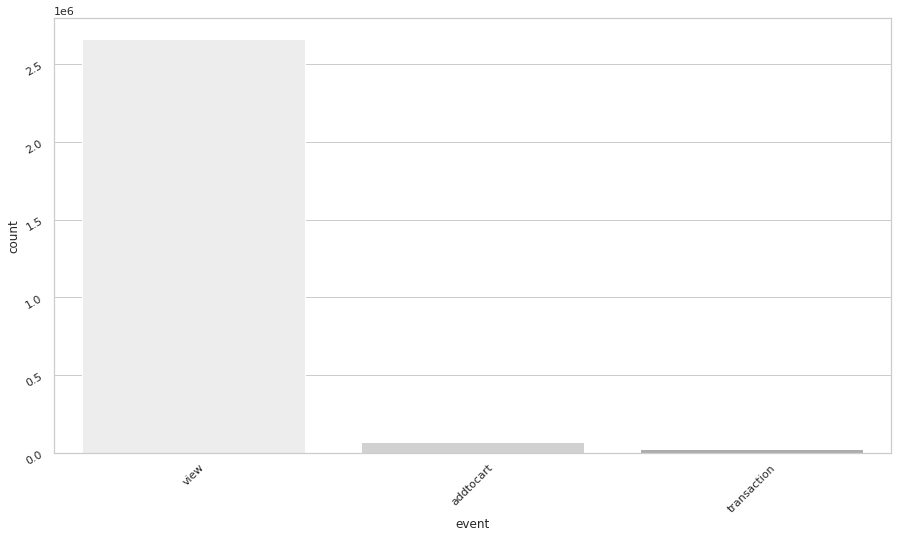

In [9]:
# events['event']
sns.set_theme(style="whitegrid", palette="Greys")
plt.xticks(rotation=45)
plt.yticks(rotation=30) 

g = sns.countplot(x='event',data =df_event)
g.figure.set_size_inches(15, 8)
# g.xaxis.set_major_locator(ticker.MultipleLocator(0))


In [10]:
# event and transactionid
# # df['event'].value_counts()
# # # view           2664312
# # # addtocart        69332
# # # transaction      22457


# event가 transaction인 경우에만 transactionid가 존재한다.
df_event.groupby('event')['transactionid'].count().reset_index().rename(columns = {'transaction_id' :'cnt_transaction_id'})


,event,transactionid
0,addtocart,0
1,transaction,22457
2,view,0


In [11]:
df_event.sort_values('timestamp',inplace=True)
df_event.reset_index(drop=True, inplace = True)
df_event.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03


In [12]:
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   datetime       datetime64[ns]
 6   date           object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


### 1️⃣. DAU, MAU, WAU, Engagement 혹은 Stickiness(DAU/MAU)

In [13]:
df_event['month'] = df_event['datetime'].dt.strftime('%Y-%m')
df_event['week'] = df_event['datetime'].dt.strftime('%Y-w%U')
df_event.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18


In [14]:
DAU = df_event.groupby('date')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})
DAU.head()

,date,cnt_visit
0,2015-05-03,13683
1,2015-05-04,19414
2,2015-05-05,23015
3,2015-05-06,23920
4,2015-05-07,23164


In [15]:
DAU['date'] = pd.to_datetime(DAU['date'])
DAU['cnt_visit'] = DAU['cnt_visit'].astype('int32')

In [16]:
DAU['month'] = DAU['date'].dt.strftime('%Y-%m')
DAU = DAU[~(DAU['month']=='2015-05')]
DAU = DAU[~(DAU['month']=='2015-09')]
DAU.reset_index(drop=True,inplace=True)
DAU

,date,cnt_visit,month
0,2015-06-01,22796,2015-06
1,2015-06-02,23336,2015-06
2,2015-06-03,23559,2015-06
3,2015-06-04,23629,2015-06
4,2015-06-05,20814,2015-06
...,...,...,...
87,2015-08-27,19566,2015-08
88,2015-08-28,19602,2015-08
89,2015-08-29,14965,2015-08
90,2015-08-30,16278,2015-08


In [20]:
# (DAU['date'].astype(str))

Text(0, 0.5, 'User_cnt')

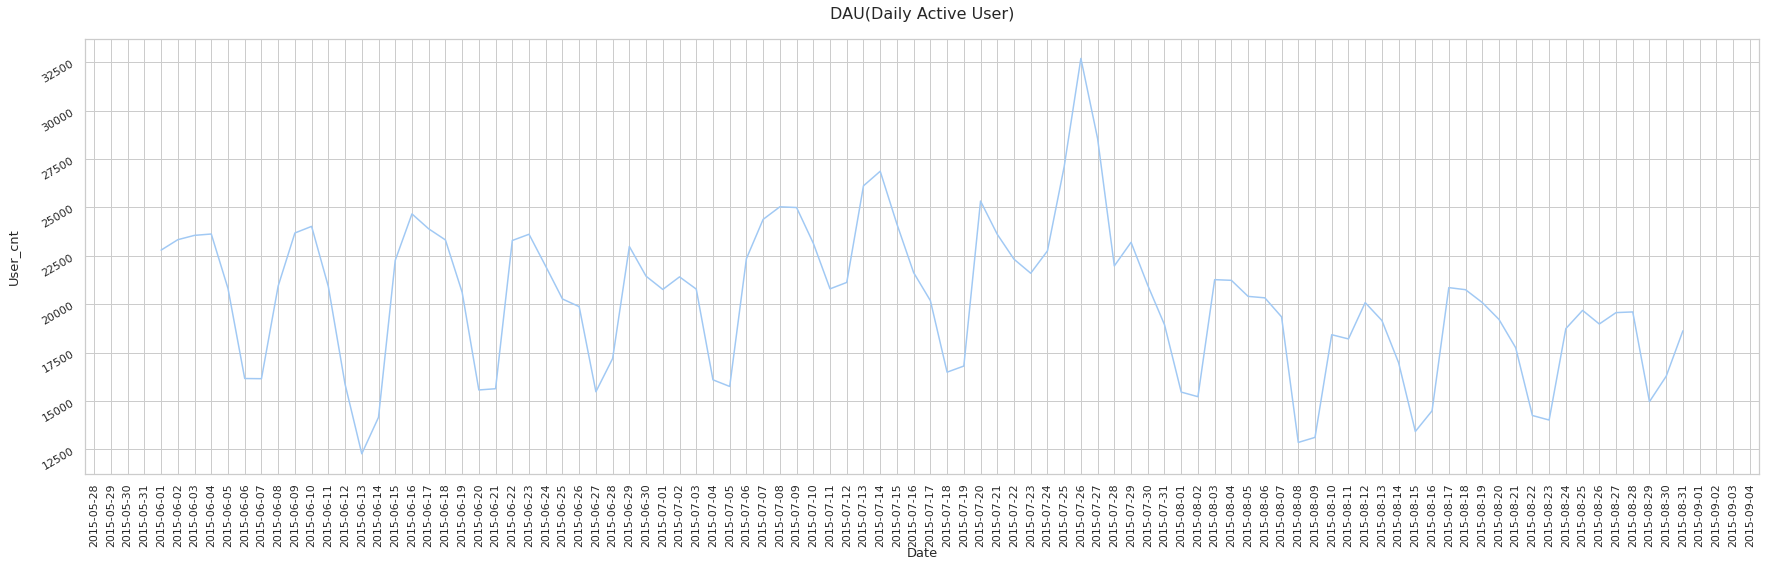

In [24]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='date', y='cnt_visit',data =DAU)
# sns.regplot(x=(DAU['date'].astype(str)), y='cnt_visit',data =DAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("DAU(Daily Active User)", pad=20, size=16)
g.set_xlabel("Date",labelpad = 0, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

In [25]:
df_event[~(df_event['month']=='2015-05')&~(df_event['month']=='2015-09')&~(df_event['week']=='2015-w35')]

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week
590652,1433116801707,778634,view,305588,NaN,2015-06-01 00:00:01.707,2015-06-01,2015-06,2015-w22
590653,1433116805891,507283,view,372845,NaN,2015-06-01 00:00:05.891,2015-06-01,2015-06,2015-w22
590654,1433116807851,673129,view,16172,NaN,2015-06-01 00:00:07.851,2015-06-01,2015-06,2015-w22
590655,1433116813138,1319671,view,21455,NaN,2015-06-01 00:00:13.138,2015-06-01,2015-06,2015-w22
590656,1433116813341,155767,view,202386,NaN,2015-06-01 00:00:13.341,2015-06-01,2015-06,2015-w22
...,...,...,...,...,...,...,...,...,...
2417481,1440892766630,541564,addtocart,44925,NaN,2015-08-29 23:59:26.630,2015-08-29,2015-08,2015-w34
2417482,1440892768422,862864,view,3383,NaN,2015-08-29 23:59:28.422,2015-08-29,2015-08,2015-w34
2417483,1440892776834,702078,view,242620,NaN,2015-08-29 23:59:36.834,2015-08-29,2015-08,2015-w34
2417484,1440892779321,577184,view,62098,NaN,2015-08-29 23:59:39.321,2015-08-29,2015-08,2015-w34


In [26]:
df_event[~(df_event['month']=='2015-05')&~(df_event['month']=='2015-09')&~(df_event['week']=='2015-w35')]\
.groupby('week')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

,week,cnt_visit
0,2015-w22,130294
1,2015-w23,133848
2,2015-w24,144498
3,2015-w25,140126
4,2015-w26,140678
5,2015-w27,156468
6,2015-w28,156566
7,2015-w29,159538
8,2015-w30,161820
9,2015-w31,130662


Text(0, 0.5, 'User_cnt')

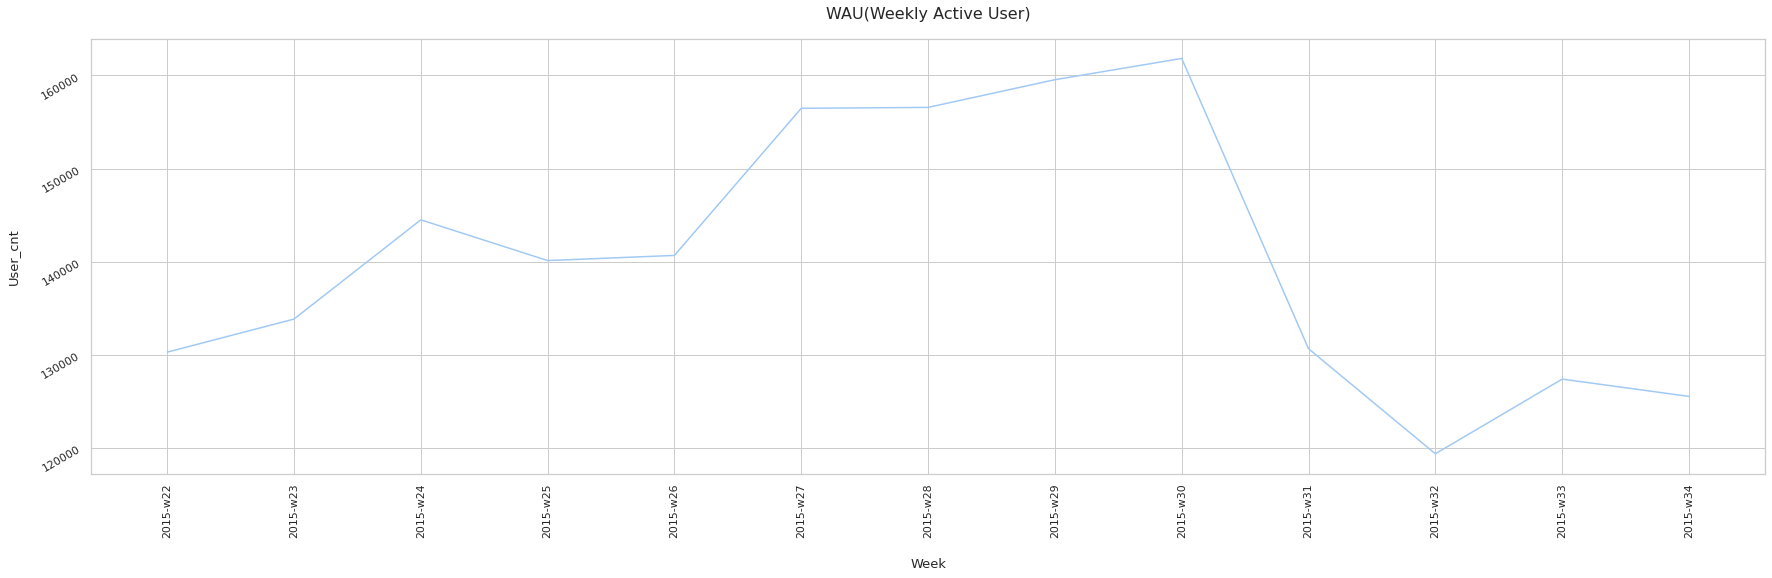

In [27]:
# WAU
WAU = df_event[~(df_event['month']=='2015-05')&~(df_event['month']=='2015-09')&~(df_event['week']=='2015-w35')]\
.groupby('week')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='week', y='cnt_visit',data =WAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("WAU(Weekly Active User)", pad=20, size=16)
g.set_xlabel("Week",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

Text(0, 0.5, 'User_cnt')

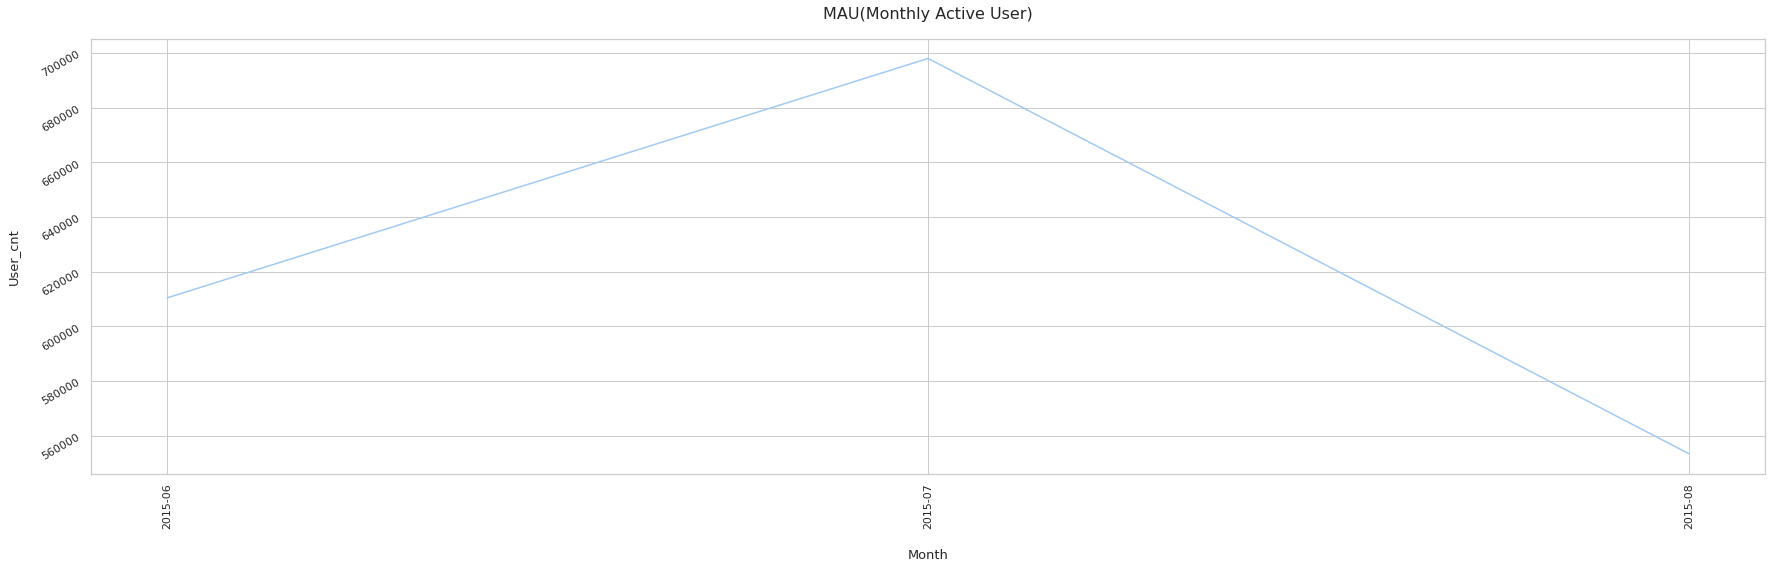

In [28]:
# MAU
MAU = df_event[~(df_event['month']=='2015-05')&~(df_event['month']=='2015-09')].groupby('month')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='month', y='cnt_visit',data =MAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("MAU(Monthly Active User)", pad=20, size=16)
g.set_xlabel("Month",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

In [29]:
# dau/mau
print('DAU : ',DAU['cnt_visit'].mean())
print('MAU : ',MAU['cnt_visit'].mean())
print('DAU/MAU : ',DAU['cnt_visit'].mean()/MAU['cnt_visit'].mean() )

# dau/mau가 거의 1/30에 가깝다. 즉, 고객의 재방문율이 떨어진다.


DAU :  20236.293478260868
MAU :  620579.6666666666
DAU/MAU :  0.03260869565217391


In [30]:
# stickiness 월별 시각화
STICKINESS = df_event.groupby('date')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})
STICKINESS['date']=pd.to_datetime(STICKINESS['date'])
STICKINESS['month'] = STICKINESS['date'].dt.strftime('%Y-%m')
STICKINESS = STICKINESS.merge(MAU, on='month')
STICKINESS['sticky'] = STICKINESS['cnt_visit_x']/STICKINESS['cnt_visit_y']
STICKY = STICKINESS.groupby('month')['sticky'].mean().reset_index().rename(columns = {'sticky':'avg_sticky'})
STICKY = STICKY[~(STICKY['month']=='2015-05')&~(STICKY['month']=='2015-05')]
STICKY

,month,avg_sticky
0,2015-06,0.033333
1,2015-07,0.032258
2,2015-08,0.032258


In [32]:
STICKY['avg_sticky']

0    0.033333
1    0.032258
2    0.032258
Name: avg_sticky, dtype: float64

In [40]:
STICKY['month'].astype(str)

0    2015-06
1    2015-07
2    2015-08
Name: month, dtype: object

In [49]:
g.text?

In [50]:
for idx, row in STICKY.iterrows():
  g.text(row.month,row.avg_sticky,str(row.avg_sticky))


In [65]:
STICKY['month']

0    2015-06
1    2015-07
2    2015-08
Name: month, dtype: object

Text(0.5, 1.0, 'Stickiness')

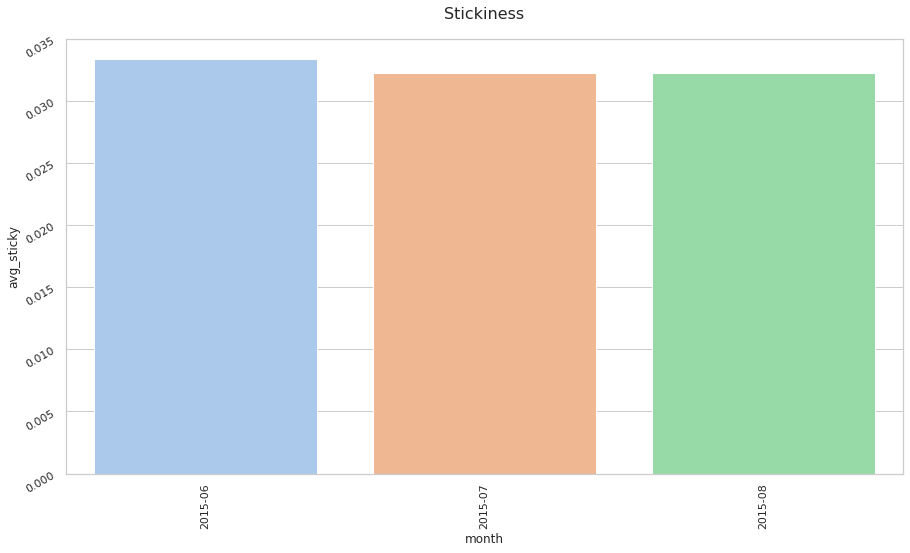

In [70]:
sns.set_theme(style = 'whitegrid', palette = 'pastel')
plt.xticks(rotation=90)
plt.yticks(rotation=30)

g = sns.barplot(x='month', y='avg_sticky',data = STICKY)
g.figure.set_size_inches(15, 8)
# g.xaxis.set_major_locator(ticker.MultipleLocator(0))
g.set_title("Stickiness", pad=20, size=16)


#### 💨 분석 내용
- DAU,WAU, MAU
  - DAU 그래프를 봤을때, 8월의 하락세는 크다
    - 7월 25~27일의 DAU는 굉장히 크다.
  - WAU 그래프를 봤을때, W27~30는 반등이 있었다.
    - 예상하건데, 특정 Campaign이 있지 않았을까 고민해볼 수 있다.
  - MAU를 봤을때, 7월>6월>8월 순이다.
    - 7월은 WAU에서 확인했던 Campaign이 주 원인이라고 판단할 수 있다.

- Stickiness 
  - (dau/mau)가 거의 1/30에 가깝다.
  - 즉, 한달 내 고객 재방문율이 떨어진다.
  - 특히나, 가장 높았던 6월대비 고객의 자의적인 재방문은 적다.


### 2️⃣. Cohort 분석
- transaction 기준

In [71]:
## 첫 방문 데이터, visitorid 기준
first_come_date = df_event[['visitorid','date']].drop_duplicates(subset = 'visitorid', keep = 'first')
first_come_date.reset_index(drop = True,inplace=True)
first_come_date = first_come_date.rename(columns ={'date':'first_date'})
first_come_date

## 275만개 data -> 140만개 data

,visitorid,first_date
0,693516,2015-05-03
1,829044,2015-05-03
2,652699,2015-05-03
3,1125936,2015-05-03
4,1149227,2015-05-03
...,...,...
1407575,998517,2015-09-18
1407576,472345,2015-09-18
1407577,1207677,2015-09-18
1407578,255126,2015-09-18


In [72]:
cohort = df_event.merge(first_come_date, how = 'left',on = 'visitorid')

## data type 변경
# cohort['date'] = cohort['date'].map(pd.to_datetime) -- map 함수는 너무 오래걸려서 skip
cohort['first_date']= pd.to_datetime(cohort['first_date'])
cohort['date']= pd.to_datetime(cohort['date'])
cohort['first_month'] = cohort['first_date'].dt.to_period('M')

# term col 추가
cohort['term'] = cohort['date'] - cohort['first_date']
cohort.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days


In [73]:
# 2회 이상 transaction이 된 경우 확인
cohort.loc[(cohort['event'] == 'transaction','visitorid')].value_counts()
# cohort[~(cohort['transactionid'].isna())].groupby('visitorid')['visitorid'].count()
# max 559회

# cohort[~(cohort['transactionid'].isna())].groupby('visitorid')['visitorid'].count().mean()
# # 평균 1.9162897858179027회

1150086    559
152963     349
530559     286
684514     189
861299     188
          ... 
356340       1
835566       1
266350       1
1083369      1
1300499      1
Name: visitorid, Length: 11719, dtype: int64

In [74]:
# transaction 발생 시, 몇번째 transaction인지 체크
cohort['transaction_cnt'] = 0 # 0으로 초기화

# 고객 별 transaction 횟수
# time 기준으로 정렬되어있으므로, rank 함수로 처리함
cohort.loc[(~cohort['transactionid'].isna(), 'transaction_cnt')] =\
cohort[~cohort['transactionid'].isna()].groupby('visitorid')['transaction_cnt'].rank(method = 'first') # -------- ★ 


In [75]:
# last visit
cohort['last_visit'] = cohort.groupby('visitorid')['date'].shift(1)

# cohort['last_visit']= cohort['last_visit'].fillna(cohort['date'])
cohort

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT


In [76]:
cohort['term_month'] = cohort['term'].dt.days # timedelta -> int로 변경
cohort['term_month'] = cohort['term_month']//30
cohort['term_month']

0          0
1          0
2          0
3          0
4          0
          ..
2756096    0
2756097    0
2756098    0
2756099    0
2756100    0
Name: term_month, Length: 2756101, dtype: int64

In [77]:
cohort[~cohort['transactionid'].isna()].reset_index(drop=True)

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month
0,1430623641391,869008,transaction,40685,9765.0,2015-05-03 03:27:21.391,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
1,1430624101772,345781,transaction,438400,1016.0,2015-05-03 03:35:01.772,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
2,1430625707591,586756,transaction,440917,10942.0,2015-05-03 04:01:47.591,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
3,1430626058961,435495,transaction,175893,6173.0,2015-05-03 04:07:38.961,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
4,1430627474903,266417,transaction,445106,12546.0,2015-05-03 04:31:14.903,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,1.0,2015-05-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22452,1442542096512,152963,transaction,12504,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,345.0,2015-09-18,1
22453,1442542096512,152963,transaction,72462,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,346.0,2015-09-18,1
22454,1442542096528,152963,transaction,380196,5772.0,2015-09-18 02:08:16.528,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,347.0,2015-09-18,1
22455,1442543898098,152963,transaction,362697,5670.0,2015-09-18 02:38:18.098,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,348.0,2015-09-18,1


In [78]:
df_cohort = cohort[~cohort['transactionid'].isna()].reset_index(drop=True)
cohort_vis = df_cohort[['first_month','term_month','visitorid']].drop_duplicates().reset_index(drop = True).groupby(['first_month','term_month']).count().rename(columns ={'visitorid':'count_visit'})
cohort_vis = cohort_vis.unstack()
cohort_vis.columns = cohort_vis.columns.droplevel(0) # multi-index 제거
cohort_vis = cohort_vis.divide(cohort_vis[0],axis=0) # 첫달껄로 다 나눠주기
cohort_vis

term_month,0,1,2,3,4
first_month,,,,,
2015-05,1.0,0.069455,0.050037,0.032114,0.007095
2015-06,1.0,0.038073,0.025641,0.006605,NaN
2015-07,1.0,0.033110,0.004092,NaN,NaN
2015-08,1.0,0.008559,NaN,NaN,NaN
2015-09,1.0,NaN,NaN,NaN,NaN


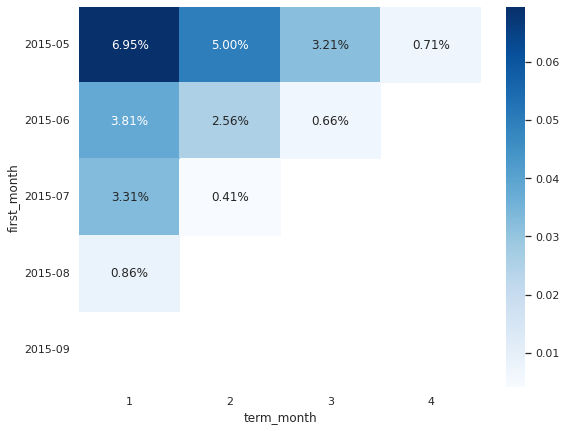

In [79]:
sns.set_theme(style="whitegrid", palette="pastel")
g = sns.heatmap(cohort_vis.iloc[:,1:], annot=True, fmt='.2%', cmap="Blues")
g.figure.set_size_inches(9, 7) 

In [93]:
# 5월에 들어온 사람들이 Retention Rate이 높다.

### 🆕. Appnedix 군집화


In [80]:
cohort.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0


In [81]:
pd.get_dummies(cohort['event'],prefix = 'event')

,event_addtocart,event_transaction,event_view
0,1,0,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2756096,0,0,1
2756097,0,0,1
2756098,0,0,1
2756099,0,0,1


In [82]:
df_clustering_temp = pd.concat([cohort, pd.get_dummies(cohort['event'],prefix = 'event')], axis=1)
df_clustering_temp

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1


In [83]:
total = df_clustering_temp.groupby('visitorid')[[x for x in df_clustering_temp.columns[-3:]]].agg(sum)
total.columns = ['total_addtocart', 'total_transaction','total_view']
total

,total_addtocart,total_transaction,total_view
visitorid,,,
0,0.0,0.0,3.0
1,0.0,0.0,1.0
2,0.0,0.0,8.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
1407575,0.0,0.0,1.0
1407576,0.0,0.0,1.0
1407577,0.0,0.0,1.0


In [84]:
df_clustering = df_clustering_temp.merge(total,how='left',on='visitorid')
df_clustering.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view,total_addtocart,total_transaction,total_view
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0,2.0,0.0,1.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1,2.0,0.0,1.0


In [85]:
df_clustering['total_event'] = df_clustering['total_addtocart'] + df_clustering['total_addtocart'] + df_clustering['total_addtocart']
df_clustering

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view,total_addtocart,total_transaction,total_view,total_event
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0,2.0,0.0,1.0,6.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1,2.0,0.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0


In [86]:
df_clustering = pd.concat([df_clustering, pd.get_dummies(df_clustering['first_month'])],axis=1)
df_clustering

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit,term_month,event_addtocart,event_transaction,event_view,total_addtocart,total_transaction,total_view,total_event,2015-05,2015-06,2015-07,2015-08,2015-09
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,1,0,0,2.0,0.0,1.0,6.0,1,0,0,0,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,1,0,0,0,0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,1,0,0,0,0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,1,0,0,0,0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03,0,0,0,1,2.0,0.0,1.0,6.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT,0,0,0,1,0.0,0.0,1.0,0.0,0,0,0,0,1


In [87]:
cluster_col = [x for x in df_clustering.columns[-8:]]

In [88]:
df_cluster= df_clustering[cluster_col]
df_cluster

,total_transaction,total_view,total_event,2015-05,2015-06,2015-07,2015-08,2015-09
0,0.0,1.0,6.0,1,0,0,0,0
1,0.0,1.0,0.0,1,0,0,0,0
2,0.0,1.0,0.0,1,0,0,0,0
3,0.0,1.0,0.0,1,0,0,0,0
4,0.0,1.0,6.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2756096,0.0,1.0,0.0,0,0,0,0,1
2756097,0.0,1.0,0.0,0,0,0,0,1
2756098,0.0,1.0,0.0,0,0,0,0,1
2756099,0.0,1.0,0.0,0,0,0,0,1


In [89]:
df_cluster.columns = ['total_transaction','total_view','total_event','5','6','7','8','9']

memory 문제로 일단 1%만 돌려보자

In [ ]:
df_for_cluster = df_cluster.sample(frac=0.01, random_state=0).reset_index(drop=True)
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9
0,0.0,1.0,0.0,1,0,0,0,0
1,0.0,1.0,0.0,0,0,0,0,1
2,0.0,2.0,0.0,0,0,1,0,0
3,0.0,11.0,0.0,1,0,0,0,0
4,0.0,8.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
55117,0.0,2.0,0.0,0,0,0,1,0
55118,0.0,4.0,0.0,1,0,0,0,0
55119,72.0,342.0,342.0,1,0,0,0,0
55120,0.0,4.0,0.0,0,0,0,1,0


In [ ]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
df_for_cluster.iloc[:,:] = stdscaler.fit_transform(df_for_cluster)
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9
0,-0.121589,-0.162579,-0.13030,1.683223,-0.54267,-0.560826,-0.466852,-0.320992
1,-0.121589,-0.162579,-0.13030,-0.594098,-0.54267,-0.560826,-0.466852,3.115346
2,-0.121589,-0.160241,-0.13030,-0.594098,-0.54267,1.783085,-0.466852,-0.320992
3,-0.121589,-0.139190,-0.13030,1.683223,-0.54267,-0.560826,-0.466852,-0.320992
4,-0.121589,-0.146207,-0.13030,-0.594098,-0.54267,1.783085,-0.466852,-0.320992
...,...,...,...,...,...,...,...,...
55117,-0.121589,-0.160241,-0.13030,-0.594098,-0.54267,-0.560826,2.142008,-0.320992
55118,-0.121589,-0.155563,-0.13030,1.683223,-0.54267,-0.560826,-0.466852,-0.320992
55119,1.905278,0.634987,2.35005,1.683223,-0.54267,-0.560826,-0.466852,-0.320992
55120,-0.121589,-0.155563,-0.13030,-0.594098,-0.54267,-0.560826,2.142008,-0.320992


In [ ]:
## elbow check
K = range(1,10)

distortions = []
for k in K:
    kmeans_cls = KMeans(n_clusters=k)
    kmeans_cls.fit(df_for_cluster)
    distortions.append(kmeans_cls.inertia_) # within-cluster sum-of-squares criterion

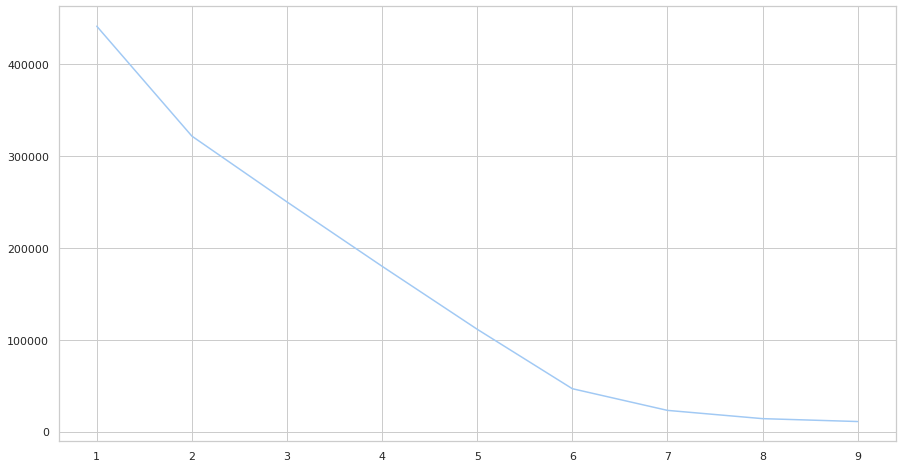

In [ ]:
g = sns.lineplot(x=K, y= distortions, markers= False, dashes=True)
g.figure.set_size_inches(15, 8) 

## 6개 군집정도로 자르면 될듯하다.

In [ ]:
#Hierarchical Clustering  #RAM이 터지네..
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=6,affinity='euclidean')
pred_AC = AC.fit_predict(df_for_cluster)


In [ ]:
df_for_cluster['class'].value_counts()

0    7450
3    6500
4    5994
2    4894
5    2573
1     150
Name: class, dtype: int64

In [ ]:
df_for_cluster['class'] = pred_AC
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9,class
0,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0
1,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,-0.467197,3.111681,5
2,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3
3,-0.123381,-0.140550,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0
4,-0.123381,-0.147644,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3
...,...,...,...,...,...,...,...,...,...
27556,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2
27557,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0
27558,-0.123381,-0.164195,-0.132167,-0.592477,1.855000,-0.565381,-0.467197,-0.321370,4
27559,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2


In [ ]:
silhouette_samples?

In [ ]:
df_for_cluster['total_transaction'].to_numpy()

array([-0.12338086, -0.12338086, -0.12338086, ..., -0.12338086,
       -0.12338086, -0.12338086])

In [ ]:
from sklearn.metrics import silhouette_samples

# Hierachical
sample_silhouette_values = silhouette_samples(df_for_cluster['total_transaction'].to_numpy().reshape(-1,1), pred_AC)

In [ ]:
df_for_cluster['silhouette_coefficient'] = sample_silhouette_values
df_for_cluster

,total_transaction,total_view,total_event,5,6,7,8,9,class,silhouette_coefficient
0,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0,-0.984942
1,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,-0.467197,3.111681,5,0.672557
2,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3,-0.672735
3,-0.123381,-0.140550,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0,-0.984942
4,-0.123381,-0.147644,-0.132167,-0.592477,-0.539084,1.768720,-0.467197,-0.321370,3,-0.672735
...,...,...,...,...,...,...,...,...,...,...
27556,-0.123381,-0.161831,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2,-0.673016
27557,-0.123381,-0.164195,-0.132167,1.687828,-0.539084,-0.565381,-0.467197,-0.321370,0,-0.984942
27558,-0.123381,-0.164195,-0.132167,-0.592477,1.855000,-0.565381,-0.467197,-0.321370,4,-0.707753
27559,-0.123381,-0.164195,-0.132167,-0.592477,-0.539084,-0.565381,2.140423,-0.321370,2,-0.673016


In [ ]:
print("Hierachical",sample_silhouette_values.mean())

Hierachical -0.588903171927142


## ✅df_item

In [91]:
# pickle load
PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'
# df_event = pd.read_pickle(PATH+"/df_event.pkl")
df_item = pd.read_pickle(PATH+"/df_item.pkl")

In [92]:
df_item.sort_values('timestamp',inplace=True)
df_item.reset_index(drop=True, inplace = True)
df_item.head()

,timestamp,itemid,property,value,datetime,date
0,1431226800000,317951,790,n32880.000,2015-05-10 03:00:00,2015-05-10
1,1431226800000,422842,480,1133979,2015-05-10 03:00:00,2015-05-10
2,1431226800000,310185,776,103591,2015-05-10 03:00:00,2015-05-10
3,1431226800000,110973,112,679677,2015-05-10 03:00:00,2015-05-10
4,1431226800000,179597,available,0,2015-05-10 03:00:00,2015-05-10


In [ ]:
df_item[df_item['itemid']==243157]

,timestamp,itemid,property,value,datetime,date
19387056,1441508400000,243157,678,567465,2015-09-06 03:00:00,2015-09-06
19394072,1441508400000,243157,categoryid,333,2015-09-06 03:00:00,2015-09-06
19489934,1441508400000,243157,888,923712,2015-09-06 03:00:00,2015-09-06
19600934,1441508400000,243157,283,648307 567465 923712 659000 639502 312815 8107...,2015-09-06 03:00:00,2015-09-06
19604757,1441508400000,243157,790,n507120.000,2015-09-06 03:00:00,2015-09-06
19635543,1441508400000,243157,764,1285872,2015-09-06 03:00:00,2015-09-06
19806090,1442113200000,243157,112,679677,2015-09-13 03:00:00,2015-09-13
19811541,1442113200000,243157,6,250259 1037547,2015-09-13 03:00:00,2015-09-13
19937137,1442113200000,243157,364,1326957,2015-09-13 03:00:00,2015-09-13
19957934,1442113200000,243157,917,923712,2015-09-13 03:00:00,2015-09-13


In [104]:
df_item['date'].value_counts()

2015-05-10    3012756
2015-05-31    2620101
2015-06-28    2368972
2015-05-24    1815598
2015-06-07    1686681
2015-08-16    1488244
2015-05-17    1027889
2015-06-14     755965
2015-07-12     593657
2015-09-13     583018
2015-08-23     571339
2015-09-06     566183
2015-07-19     563575
2015-08-09     542778
2015-08-30     532586
2015-08-02     529315
2015-07-26     519460
2015-07-05     497785
Name: date, dtype: int64

### ?????. User별 Transaction 전환 체크

In [96]:
df_event['event'].value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [140]:
df_event[df_event['itemid']== 317951]

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week
90199,1431011474961,92384,view,317951,NaN,2015-05-07 15:11:14.961,2015-05-07,2015-05,2015-w18
90211,1431011496672,92384,view,317951,NaN,2015-05-07 15:11:36.672,2015-05-07,2015-05,2015-w18
90311,1431011843797,92384,view,317951,NaN,2015-05-07 15:17:23.797,2015-05-07,2015-05,2015-w18
254087,1431728853702,1120372,view,317951,NaN,2015-05-15 22:27:33.702,2015-05-15,2015-05,2015-w19
558519,1432945065013,735001,view,317951,NaN,2015-05-30 00:17:45.013,2015-05-30,2015-05,2015-w21
634060,1433282371729,1084658,view,317951,NaN,2015-06-02 21:59:31.729,2015-06-02,2015-06,2015-w22
634064,1433282382313,1084658,view,317951,NaN,2015-06-02 21:59:42.313,2015-06-02,2015-06,2015-w22
634068,1433282396205,1084658,view,317951,NaN,2015-06-02 21:59:56.205,2015-06-02,2015-06,2015-w22
872460,1434338981042,940899,view,317951,NaN,2015-06-15 03:29:41.042,2015-06-15,2015-06,2015-w24
983860,1434758859394,1014843,view,317951,NaN,2015-06-20 00:07:39.394,2015-06-20,2015-06,2015-w24


In [106]:
df_item['value'].value_counts()

769062                                                                                                                                                                                                                                               1537247
0                                                                                                                                                                                                                                                     863246
1                                                                                                                                                                                                                                                     641420
679677                                                                                                                                                                                                                                           

In [142]:
df_item[df_item['itemid']==317951]

0                                                  n32880.000
265051                                          990525 188678
1594612                                               1105156
2132295                                                519769
2405302                                                481999
                                  ...                        
19507497                                        481999 961511
19659529                                           n18720.000
19903453                                        481999 961511
20208512                                           n18720.000
20252011    n1200.000 1175087 n1200.000 n2400.000 1175087 ...
Name: value, Length: 75, dtype: object

In [120]:
df_item

,timestamp,itemid,property,value,datetime,date
0,1431226800000,317951,790,n32880.000,2015-05-10 03:00:00,2015-05-10
1,1431226800000,422842,480,1133979,2015-05-10 03:00:00,2015-05-10
2,1431226800000,310185,776,103591,2015-05-10 03:00:00,2015-05-10
3,1431226800000,110973,112,679677,2015-05-10 03:00:00,2015-05-10
4,1431226800000,179597,available,0,2015-05-10 03:00:00,2015-05-10
...,...,...,...,...,...,...
20275897,1442113200000,364708,928,769062,2015-09-13 03:00:00,2015-09-13
20275898,1442113200000,231604,888,561561 1055803 447378 n12.000 1135780 1284577 ...,2015-09-13 03:00:00,2015-09-13
20275899,1442113200000,161357,888,12762 16970 145048 237874 1229126 784581 12977...,2015-09-13 03:00:00,2015-09-13
20275900,1442113200000,267142,available,0,2015-09-13 03:00:00,2015-09-13


In [133]:
df_item['value_lst'] = df_item['value'].str.split(' ')

0                                                [n32880.000]
1                                                   [1133979]
2                                                    [103591]
3                                                    [679677]
4                                                         [0]
                                  ...                        
20275897                                             [769062]
20275898    [561561, 1055803, 447378, n12.000, 1135780, 12...
20275899    [12762, 16970, 145048, 237874, 1229126, 784581...
20275900                                                  [0]
20275901                [888666, n10800.000, 746840, 1318567]
Name: value_lst, Length: 20275902, dtype: object

In [110]:
df_item.iloc[:100,:]['value'].str.split(' ')[0]

['n32880.000']